In [146]:
'''
1 (c)
'''
from tensorflow.keras.preprocessing.text import Tokenizer
# books = ["The Problems of Philosophy", "The Analysis of Mind", "Mysticism and Logic and Other Essays",
#         "Our Knowledge of the External World as a Field for Scientific Method in Philosophy",
#          "The History of Western Philosophy","The Analysis of Matter"]
books = ["The Problems of Philosophy", "The Analysis of Mind", "Mysticism and Logic and Other Essays",
        "Our Knowledge of the External World as a Field for Scientific Method in Philosophy"]

In [147]:
'''
1 (c) ii
'''
#character we concern
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{} "
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i
text = ""
for i in range (len(books)):
    temp_book = open(books[i] + ".txt", "r")
    text += temp_book.read()
tokenizer = Tokenizer(num_words=None, char_level=True, oov_token='UNK')
tokenizer.fit_on_texts(text)
tokenizer.word_index = char_dict.copy()
tokenizer.word_index[tokenizer.oov_token] = max(char_dict.values()) + 1
char_dict = tokenizer.word_index.copy()

#index to char dict
reversed_dictionary = dict(zip(char_dict.values(), char_dict.keys()))
reversed_dictionary[max(char_dict.values())] = ' ' 

print(tokenizer.word_index)
sequences = tokenizer.texts_to_sequences(text)
train_data = []
for i in range (len(sequences)):
    train_data.append(sequences[i][0] / (70))
    


{'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '0': 26, '1': 27, '2': 28, '3': 29, '4': 30, '5': 31, '6': 32, '7': 33, '8': 34, '9': 35, ',': 36, ';': 37, '.': 38, '!': 39, '?': 40, ':': 41, "'": 42, '"': 43, '/': 44, '\\': 45, '|': 46, '_': 47, '@': 48, '#': 49, '$': 50, '%': 51, '^': 52, '&': 53, '*': 54, '~': 55, '`': 56, '+': 57, '-': 58, '=': 59, '<': 60, '>': 61, '(': 62, ')': 63, '[': 64, ']': 65, '{': 66, '}': 67, ' ': 68, 'UNK': 69}


In [148]:
print(len(train_data))

1596417


In [179]:
'''
1 (c) iii
'''
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, LSTM
from tensorflow.keras.utils import to_categorical
WINDOW_SIZE = 100
NUM_STEPS = 99
BATCH_SIZE = 1000
STRIDES = 1 
#69 + 1 = 70
VOCABULARY = max(char_dict.values()) + 1 

memory_unit = VOCABULARY
train_data = np.transpose(train_data)

#Credit: https://adventuresinmachinelearning.com/keras-lstm-tutorial/
class KerasBatchGenerator(object):

    def __init__(self, data, num_steps, batch_size, vocabulary, skip_step):
        self.data = data
        self.num_steps = num_steps
        self.batch_size = batch_size
        self.vocabulary = vocabulary
        # this will track the progress of the batches sequentially through the
        # data set - once the data reaches the end of the data set it will reset
        # back to zero
        self.current_idx = 0
        # skip_step is the number of words which will be skipped before the next
        # batch is skimmed from the data set
        self.skip_step = skip_step

    def generate(self):
        x = np.zeros((self.batch_size, self.num_steps, 1))
        y = np.zeros((self.batch_size, self.vocabulary))
        while True:
            for i in range(self.batch_size):
                if self.current_idx + self.num_steps + 1 >= len(self.data):
                    # reset the index back to the start of the data set
                    self.current_idx = 0
                    
                x[i, :, :] = [[char] for char in self.data[self.current_idx:self.current_idx + self.num_steps]]
                temp_y = self.data[self.current_idx + self.num_steps:self.current_idx + self.num_steps + 1]
                # convert temp_y into a one hot representation
                temp_y = round(self.vocabulary * temp_y[0]) - 1
                y[i, :] = to_categorical(temp_y, num_classes=self.vocabulary)
                self.current_idx += self.skip_step
            yield x, y
            
train_data_generator = KerasBatchGenerator(train_data, NUM_STEPS, BATCH_SIZE, VOCABULARY,
                                           skip_step=STRIDES)

#build the keras model 
model = Sequential()
#Word embedding https://stackoverflow.com/questions/46155868/keras-embedding-layer
#model.add(Embedding(VOCABULARY, 8, input_length=NUM_STEPS))
model.add(LSTM(memory_unit, return_sequences=False, input_shape=(99,1)))
model.add(Dropout(0.2))
model.add((Dense(VOCABULARY)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_61 (LSTM)               (None, 70)                20160     
_________________________________________________________________
dropout_51 (Dropout)         (None, 70)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 70)                4970      
_________________________________________________________________
activation_49 (Activation)   (None, 70)                0         
Total params: 25,130
Trainable params: 25,130
Non-trainable params: 0
_________________________________________________________________
None


In [196]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 30
cur_path = os.getcwd()
filepath= cur_path + "/model-{epoch:02d}-{loss:.4f}.hdf5"

# define the checkpoint
checkpoint = ModelCheckpoint(filepath, monitor = "loss", verbose = 1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
model.fit_generator(train_data_generator.generate(), (len(train_data) - 99)//(BATCH_SIZE), NUM_EPOCHS, callbacks=callbacks_list)


#print index to content
# print(reversed_dictionary)
# for e in sequences[:300]: 
#     print(reversed_dictionary[e[0]], end="")

Epoch 1/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.8224 - categorical_accuracy: 0.2136
Epoch 00001: loss improved from inf to 2.82240, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-01-2.8224.hdf5
1596/1596 [==============================] - 1867s 1s/step - loss: 2.8224 - categorical_accuracy: 0.2136
Epoch 2/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.7780 - categorical_accuracy: 0.2202
Epoch 00002: loss improved from 2.82240 to 2.77798, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-02-2.7780.hdf5
1596/1596 [==============================] - 1860s 1s/step - loss: 2.7780 - categorical_accuracy: 0.2202
Epoch 3/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.7376 - categorical_accuracy: 0.2246
Epoch 00003: loss improved from 2.77798 to 2.73751, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-03-2.7375.hdf5
1596/1596 [==============================] - 1857s 1s/step - loss: 2.7375 - categorica

Epoch 25/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.4000 - categorical_accuracy: 0.3076
Epoch 00025: loss improved from 2.40888 to 2.39994, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-25-2.3999.hdf5
1596/1596 [==============================] - 2109s 1s/step - loss: 2.3999 - categorical_accuracy: 0.3076
Epoch 26/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.3921 - categorical_accuracy: 0.3097
Epoch 00026: loss improved from 2.39994 to 2.39206, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-26-2.3921.hdf5
1596/1596 [==============================] - 2041s 1s/step - loss: 2.3921 - categorical_accuracy: 0.3097
Epoch 27/30
1595/1596 [============================>.] - ETA: 1s - loss: 2.3847 - categorical_accuracy: 0.3115
Epoch 00027: loss improved from 2.39206 to 2.38467, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/model-27-2.3847.hdf5
1596/1596 [==============================] - 2082s 1s/step - loss: 2.3847 - cat

In [203]:
'''
1 (xi)
'''# https://machinelearningmastery.com/text-generation-lstm-recurrent-neural-networks-python-keras/
load_filepath= "model-30-2.3642.hdf5"
model.load_weights(load_filepath)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

init_text = "There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object."
print (init_text, end="")
input_text = init_text[len(init_text) - 99 : ]
# generate characters
for i in range(1000):
    x = [char_dict[char.lower()] for char in input_text]
    x = np.reshape(x, (1, len(x), 1))
    x = x / VOCABULARY
    prediction = model.predict(x, verbose=0)
    index = np.argmax(prediction)
    result = reversed_dictionary[index]
    print(result, end="")
    input_text += result
    input_text = input_text[1:]
    

There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.}sgd}rdqdshnm}ne}sgdr}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}sgd}rg sgd}

In [1]:
'''
2 (a,b,c)
'''
import numpy as np
import pickle
import os
from random import randint
cur_path = os.getcwd()
image_file_path = cur_path + "/cifar-10-batches-py/data_batch_"
dicts = []
for i in range (5):
    infile = open(image_file_path+ str(i+1),'rb')
    new_dict = pickle.load(infile, encoding='latin1')
    dicts.append(new_dict)
image_test_file_path = cur_path + "/cifar-10-batches-py/test_batch"
test_file = open(image_test_file_path,'rb')
test_dict = pickle.load(test_file, encoding='latin1')    
dicts.append(test_dict)

In [2]:
# third is bird, index 2
bird_images = []
for i in range (len(dicts)):
    array = np.array(dicts[i]["labels"])
    indexes = np.argwhere(array == 2).ravel()
    for index in indexes: 
        bird_images.append(dicts[i]["data"][index])

In [3]:
bird_pixels = [] 
for i in range(len(bird_images)):
    temp_pixel = []
    for j in range(1024):
        #RGB
        temp_pixel.append([bird_images[i][j], bird_images[i][j+1024], bird_images[i][j+2048]])
    bird_pixels.append(temp_pixel)
    

In [47]:
random_pixels = []
for i in range (len(bird_pixels)):
    for j in range (1024):
        random_pixels.append(bird_pixels[i][j])
print(len(random_pixels))

6144000


In [48]:
'''
2 (d)
'''
from sklearn.cluster import KMeans
X = np.array(random_pixels)
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

In [ ]:
#time consuming 30min
#convert to nearest kneighbors
colors = [[255, 255, 255], [170, 255, 195],[230, 25, 75], [0,0,128]]
bird_pixels_clustered = []
for i in range (len(bird_pixels)):
    temp_pixels = []
    for j in range (1024):
        cluster = kmeans.predict([bird_pixels[i][j]])
        temp_pixels.append(colors[cluster[0]])
    bird_pixels_clustered.append(temp_pixels)
print(len(bird_pixels_clustered) )      

In [4]:
colors = [[255, 255, 255], [170, 255, 195],[230, 25, 75], [0,0,128]]
bird_filename = 'bird_pixels_clustered'
# outfile = open(bird_filename,'wb')
# pickle.dump(bird_pixels_clustered,outfile)
# outfile.close()
infile = open(bird_filename,'rb')
bird_pixels_clustered_copy = pickle.load(infile)
infile.close()
print(len(bird_pixels_clustered_copy))

6000


In [5]:
'''
2 (e)
'''
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
color_codes = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
#DRAW IMAGE DATA WITH MTP
# clustered_data = np.reshape(bird_pixels_clustered_copy[1], (32, 32, 3))
# imgplot = plt.imshow(clustered_data)

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])
gray_birds = []
for image in bird_pixels_clustered_copy:
    gray_birds.append(rgb2gray(np.reshape(image, (32, 32, 3))))

bird_output = []
for image in bird_pixels_clustered_copy:
    temp_output = []
    for j in range (1024): 
        for k in range (len(color_codes)): 
            if image[j] == colors[k]:
                #only in one time
                temp_output.append(color_codes[k])
    bird_output.append(temp_output)
    
targets = np.array(bird_output)
data = np.array(gray_birds)
data = np.reshape(data,(6000, 32, 32, 1))
#normailize grayscale 0-1 
data = data / 255


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, Dropout, TimeDistributed, LSTM, MaxPooling2D, Conv2D, Flatten, Reshape
from tensorflow.keras.utils import to_categorical
NUM_OF_FILTERS = 4
model = Sequential()
model.add(Conv2D(NUM_OF_FILTERS, (5, 5),padding='same', input_shape=(32,32,1)))
model.add(Conv2D(NUM_OF_FILTERS, (5, 5), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(4096))
model.add(Activation('softmax'))
model.add(Reshape((1024,4)))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 4)         104       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 4)         404       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 4)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              4198400   
_________________________________________________________________
acti

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
X_train, X_test, y_train, y_test = train_test_split(data, targets, test_size=0.20, random_state=42)

cur_path = os.getcwd()
filepath= cur_path + "/bird-{epoch:02d}-{loss:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor = "loss", verbose = 1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

history = model.fit(X_train, y_train, batch_size=100, epochs=30, verbose=1,validation_data=(X_test, y_test),callbacks=callbacks_list)


Train on 4800 samples, validate on 1200 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
4700/4800 [============================>.] - ETA: 0s - loss: 1.1800 - acc: 0.4469
Epoch 00001: loss improved from inf to 1.17722, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-01-1.1772.hdf5
4800/4800 [==============================] - 10s 2ms/sample - loss: 1.1772 - acc: 0.4490 - val_loss: 1.0507 - val_acc: 0.5364
Epoch 2/30
4700/4800 [============================>.] - ETA: 0s - loss: 0.9763 - acc: 0.5789
Epoch 00002: loss improved from 1.17722 to 0.97488, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-02-0.9749.hdf5
4800/4800 [==============================] - 9s 2ms/sample - loss: 0.9749 - acc: 0.5798 - val_loss: 0.9384 - val_acc: 0.5973
Epoch 3/30
4700/4800 [============================>.] - ETA: 0s - loss: 0.8811 - acc: 0.6298
Epoch 00003: loss improved from 0.97488 to 0.88064, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-03-0.8806.hdf5
480

Epoch 24/30
4700/4800 [============================>.] - ETA: 0s - loss: 0.2563 - acc: 0.9090
Epoch 00024: loss improved from 0.27425 to 0.25680, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-24-0.2568.hdf5
4800/4800 [==============================] - 9s 2ms/sample - loss: 0.2568 - acc: 0.9088 - val_loss: 0.9325 - val_acc: 0.7076
Epoch 25/30
4700/4800 [============================>.] - ETA: 0s - loss: 0.2439 - acc: 0.9138
Epoch 00025: loss improved from 0.25680 to 0.24417, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-25-0.2442.hdf5
4800/4800 [==============================] - 9s 2ms/sample - loss: 0.2442 - acc: 0.9136 - val_loss: 0.9409 - val_acc: 0.7033
Epoch 26/30
4700/4800 [============================>.] - ETA: 0s - loss: 0.2323 - acc: 0.9182
Epoch 00026: loss improved from 0.24417 to 0.23278, saving model to /Users/kuirensu/Desktop/INF552HW/HW7/bird-26-0.2328.hdf5
4800/4800 [==============================] - 10s 2ms/sample - loss: 0.2328 - acc: 0.9180 - va

In [8]:
error_data = []
train_accuracy = history.history['acc']
test_accuracy = history.history['val_acc']
error_data.append(1 - np.array(train_accuracy))
error_data.append(1 - np.array(test_accuracy))
prediction = model.predict([X_test[0:10]], verbose=0)
# outfile = open("bird_y_test",'wb')
# pickle.dump(y_test,outfile)
# outfile.close()
# outfile = open("bird_train_test_error",'wb')
# pickle.dump(error_data,outfile)
# outfile.close()
# outfile = open("ten_prediction",'wb')
# pickle.dump(prediction,outfile)
# outfile.close()

In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
colors = [[255, 255, 255], [170, 255, 195],[230, 25, 75], [0,0,128]]
infile = open("bird_train_test_error",'rb')
error_data = pickle.load(infile)
infile.close()
infile = open("ten_prediction",'rb')
prediction = pickle.load(infile)
infile.close()
infile = open("bird_y_test",'rb')
y_test = pickle.load(infile)
infile.close()
#Generate 10 predicted images
ten_test_results = []
for i in range(len(prediction)):
    temp_image = []
    for j in range (1024): 
        index = np.argmax(prediction[i][j])
        temp_image.append(colors[index])
    temp_image = np.array(temp_image)
    temp_image = np.reshape(temp_image,(32, 32, 3))
    ten_test_results.append(temp_image)


In [12]:
#Convert 10 test labels to images
ten_y_test = []
for i in range(10):
    temp_image = []
    for j in range (1024): 
        index = np.argwhere(y_test[i][j] == 1)
        
        temp_image.append(colors[index[0][0]])
    temp_image = np.array(temp_image)
    temp_image = np.reshape(temp_image,(32, 32, 3))
    ten_y_test.append(temp_image)

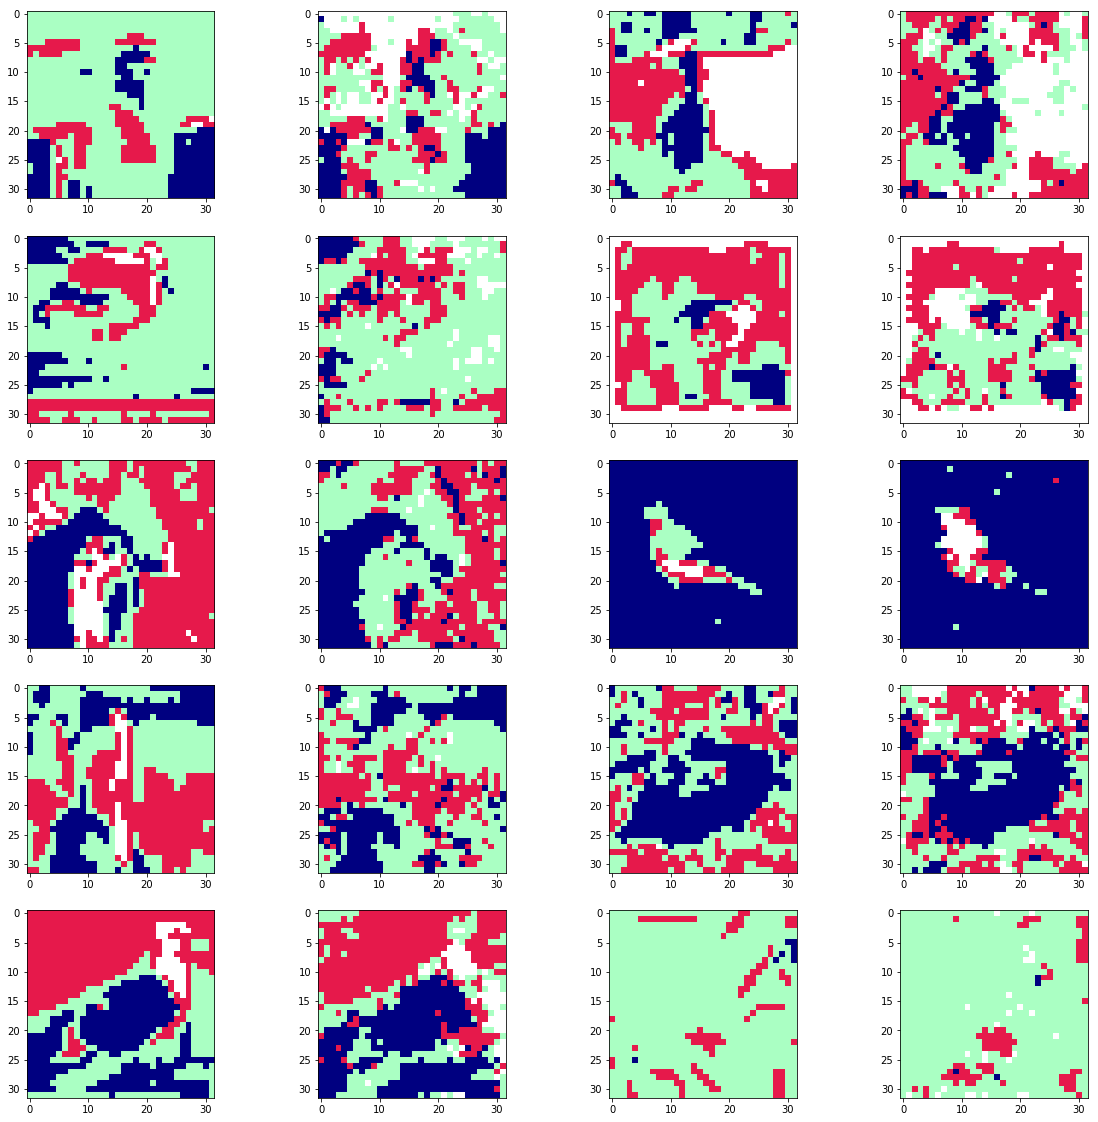

In [14]:
#Plot multiple images 
#https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
fig=plt.figure(figsize=(20, 20))
columns = 4
rows = 5
for i in range(1, 11):
    fig.add_subplot(rows, columns, i*2-1)
    plt.imshow(ten_y_test[i-1])
    fig.add_subplot(rows, columns, i*2)
    plt.imshow(ten_test_results[i-1])
plt.show()

Text(0.5, 1.0, 'Error Curves')

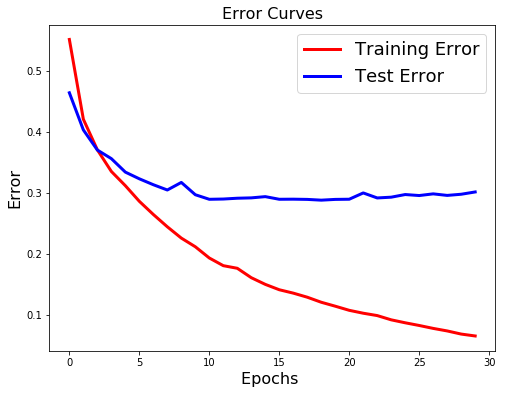

In [17]:
# Error Curves
plt.figure(figsize=[8,6])
plt.plot(error_data[0],'r',linewidth=3.0)
plt.plot(error_data[1],'b',linewidth=3.0)
plt.legend(['Training Error', 'Test Error'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Error',fontsize=16)
plt.title('Error Curves',fontsize=16)
  
